# Матрица Теплица и циркулянт.

Ранее мы решали уравнение Пуассона используя LU разложение для матрицы дискретизованного оператора Лапласа
(см. [эту лабораторную](lu.ipynb)).
Использование особенностей конкретной матрицы позволяет ускорять вычисления,
в прошлой лабораторной мы использовали представление в виде блочной [ленточной матрицы](https://en.wikipedia.org/wiki/Band_matrix).
Равенство нулю всех элементов ленточной матрицы, кроме нескольких диагоналей, 
позволяет значительно сократить объем вычислений,
и к счастью, дискретизация дифференциальных операторов дает именно ленточные матрицы.
Ширина "ленты" зависит от выбора дискретизации и ее порядка точности.
Обратная матрица к ленточной уже вообще говоря не является ленточной,
например, матрица резольвенты $(\Delta-\zeta)^{-1}$ не содержит нулевых элементов.
Матрицы резольвенты в нашем случае, однако, не является матрицей общего вида,
так как пространство в задаче было изотропным, а следовательно элементы матрицы 
зависили только от разницы индексов, т.е. все элементы одной диагонали совпадали.
Такого рода матрицы ествественным образом возникают во многих физических задачах,
поэтому желательно иметь для них максимально быстрые методы счета.
В настоящей лабораторной мы изучим, как использовать свойство равенства всех элементов каждой диагонали друг-другу для ускорения вычислений.

В прошлой лабораторной мы учли обращение в ноль мноих элементов матрицы $A$, получающейся дискетизаций
оператора Лапласа $\Delta=\partial_x^2+\partial_y^2$ 
конечными разностями на равномерной решетке 
$x_k=\frac{k-N}{N}$, $y_n=\frac{n-N}{N}$:
$$A_{k,n;k',n'}=\begin{cases}
N^2,& |n-n'|+|k-k'|=1,\\
-4N^2, & n=n', k=k',\\
0,& \text{в остальных случаях}.
\end{cases}.$$
Мы, однако, не учли равенство всех элементов одной (блочной) диагонали,
а именно, все элементы матрицы $A$ можно задать в терминах одного вектора $a$:
$$A_{k,n;k',n'}=a_{k-k',n-n'}.$$
Другими словами, действие матрицы $A$ на произвольных вектор $x$ эквивалентно свертке 
векторов $x$ и $a$ (по двум индексам сразу):
$$(Ax)_{k,n}=\sum_{k',n'}A_{k,n;k'n'}x_{k',n'}
=\sum_{k',n'} a_{k-k',n-n'} x_{k',n'}
=(a* x)_{k,n}.$$
Матриц, которые имеют равные элементы на каждой из диагоналей, называются [матрицами Теплица](https://en.wikipedia.org/wiki/Toeplitz_matrix).
Элементы разных диагоналей вообще говоря не совпадают,
так что математический аппарат матриц Теплица можно использовать и в случае, 
когда все коэффициенты $a_{n,k}$ отличны.
Тем не менее, наличие дополнительных симметрий позволяет ускорить расчеты и облегчить
обоснование корректности метода и оценки ошибок.

Нашей задачей снова будет решение уравнения Пуассона 
$\Delta u(x,y)=f(x,y)$ на квадрате $(x,y)\in[-1,1]^{\times 2}$ с периодическими граничными условиями 
$$\begin{cases}
u(-1,y)=u(1,y),\;\partial_x u(-1,y)=\partial_x u(1,y),\\
u(x,-1)=u(x,1),\;\partial_y u(x,-1)=\partial_y u(x,1),
\end{cases}
$$
в дискретизованном виде $Au=f$, где вектора заданы на равномерной сетке:
$u_{kn}=u(x_k,y_n),\quad f_{kn}=f(x_k,y_n)$.
Для однозначного задания решения положим $u(-1,-1)=0$.
Решение системы с матрицей Теплица может быть проведено за время $O(N^2)$
[алгоритмом Левинсона](https://en.wikipedia.org/wiki/Levinson_recursion), 
против сложности $O(N^3)$ для матрицы общего вида.

## Задания

1. Убедитесь, что матрица $A$ является (1) блочной матрицей Теплица, (2) блочной ленточной матрицей, (3) симметрической
матрицей, (4) неположительно определенной матрицей. Какие алгоритмы можно использовать для специальных матриц такого вида?

2. Реализуйте алгоритм Левинсона для блочных матриц (можно воспользоваться классами для блочных матриц из прошлой лабораторной). Как можно усовершенствовать алгоритм для ленточных матриц и для симметрических матриц? Решите уравнение Пуассона решателем линейных систем с блочными ленточными симметрическими матрицами Теплица. В качестве правой части системы возьмите $f(x,y)=\cos \pi x\cos \pi y$. Оцените точность решения.
Оцените сложность полученного алгоритма по времени.

In [3]:
#2
from sourse import FullMatrix, Toeplitz, L
import numpy as np
import matplotlib.pyplot as plt

Проверим работу класса

In [4]:
T = Toeplitz([0, 0, 1], [-2, 1, 0, 0])

T.print()

[-2, 1, 0, 0]
[1, -2, 1, 0]
[0, 1, -2, 1]
[0, 0, 1, -2]


In [5]:
x = np.array(T.levinson(y=[0, 4, 7, -1]))
x

array([ -5., -10., -11.,  -5.])

In [6]:
T.data().dot(x.T)

array([ 0.,  4.,  7., -1.])

In [7]:
def D(n=4):
    mat = L(n=n).m

    return Toeplitz(mat[1:, 0][::-1], mat[:, 0])

f = lambda x, y: np.cos(np.pi * x) * np.cos(np.pi * y)

def Y(n=4):
    points = np.linspace(-1, 1, n)
    y_true = np.ravel([[f(x, y) for x in points] for y in points])
    y_true -= np.sum(y_true)
    d = D(n=n).data()
    y_right = d.dot(y_true.T)
    return y_right, y_true

In [14]:
# Проверим, что матрица теплицова

M = L(n=10).m.reshape((10, 10, 10, 10))


print(np.max((np.roll(np.roll(M, shift=1, axis=1), shift=1, axis=3) - M).reshape((10**2,10**2))))

0


max Delta = 8.941403173423623e-12


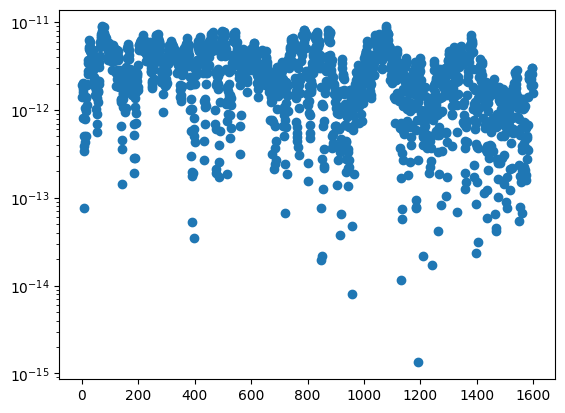

In [15]:
n = 40

d = D(n)
y_right, y_left = Y(n)

res = d.levinson(y_right)

plt.scatter(np.arange(n**2), np.abs((res - y_left)))
plt.yscale('log')
print(f"max Delta = {np.max(np.abs(res - y_left))}")

Text(0.5, 1.0, 'N=400')

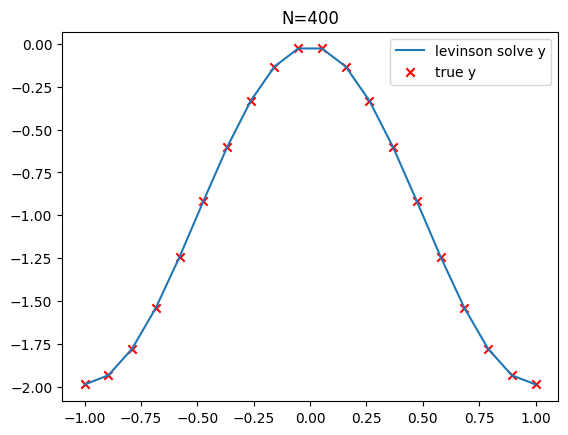

In [12]:
n = 20

d = D(n)
y_right, y_left = Y(n)

res = d.levinson(y_right) 
#res /= max(res)

points = np.linspace(-1, 1, n)

m = 10
plt.plot(points, res[m*n:(m+1)*n], label='levinson solve y')
plt.scatter(points, y_left[m*n:(m+1)*n], label='true y', marker='x', c='r')
plt.legend()
plt.title(f"N={n**2}")


Среди всех матриц Теплица выделяют матрицы, все строки которых можно получить циклическими перестановками одной строки.
Матрицы такого вида называют [матрицей циркулянта.](https://en.wikipedia.org/wiki/Circulant_matrix) 
Циркулянты естественно возникают при изучении периодических систем,
в частности, изучаемое уравнение Пауссона на квадрате, приводит к циркулянту.
Действие матрицы циркулятна на вектор записывается в виде свертки, 
как и для матрицы Теплица выше, но количество произвольных коэффициентов в случае циркулянта меньше:
$$
(Ax)_{k,n}=\sum_{k',n'}a_{k-k'\mathrm{mod} N,n-n'\mathrm{mod} N} x_{k',n'},
$$
Заметим, что матрица циркулянта с двумя побочными диагоналями не является ленточной матрицей, так как она содержит левый нижний и правый верхних углы, например, для матрицы $5\times 5$:
$$\begin{pmatrix}
\alpha&\beta&0&0&\gamma\\
\gamma&\alpha&\beta&0&0\\
0&\gamma&\alpha&\beta&0\\
0&0&\gamma&\alpha&\beta\\
\beta&0&0&\gamma&\alpha
\end{pmatrix}.$$
Наличие "углов" затрудняло использование решателя для ленточных матриц для уравнения Пуассона и треловало использования формулы [Шермана-Моррисона-Вудбери](https://en.wikipedia.org/wiki/Woodbury_matrix_identity).
В циркулянте "углы" возникают естественно и могут обсчитываться очень эффективно.

Матрица циркулянта может быть диагонализована с помощью дискретного преобразования Фурье,
задаваемого матрицей 
$$F_{n;n'}=\theta^{nn'},\quad \theta=e^{-i2\pi/N},$$
где $N$ - размерность пространства.
В случае матрицы $A$ преобразование Фурье нужно применить по обоим индексам:
$$(F\otimes F)A(F\otimes F)^*=\Lambda,$$
где $\otimes$ обозначает [тензорное произведение матриц](https://en.wikipedia.org/wiki/Kronecker_product),
а матрица $\Lambda$ диагональная и ее диагональ состоит из координат вектора $(F\otimes F)a$.
Этот факт другими словами записывается так: преобразование Фурье переводит свертку векторов в поэлементное перемножение их Фурье образов.

Диагонализация матрицы циркулянта может быть использована для решения системы $Au=f$.
В терминах Фурье образов уравнение принимает вид $\Lambda (F\otimes F)u = (F\otimes F)f$ с диагональной матрицей $\Lambda$,
а значит для решения системы достаточно поделить правую часть на диагонал матрицы $\Lambda$ поэлементно.
Следовательно, явная формула для решения системы с циркулянтом принимает вид:
$$
u=(F^*\otimes F^*)\Lambda^{-1}(F\otimes F)f.
$$
Чтобы алгоритм был практически полезен, нужно уметь быстро вычислять прямое и обратное преобразование Фурье.
К счастью, алгоритм [быстрого преобразования Фурье](https://en.wikipedia.org/wiki/Fast_Fourier_transform)
позволяет вычислить $Fx$ на $N$ мерном векторе $x$ за время $O(N\log N)$.
Так как двухмерное преобразование $F\otimes F$ можно вычислить последовательно применяя $F$ по одной переменной и по другой переменной, то сложность вычисления действия $F\otimes F$ на вектор также $O(N\log N)$,
где $N$ на этот раз равно числу координат вектора $x$.
Так как сложность вычисления $\Lambda^{-1}x$ равна $O(N)$,
итоговая сложность решения системы методом преобразования Фурье равна $O(N\log N)$,
что значительно лучше сложности решения системы общего вида $O(N^3)$ или решения системы с матрицей Теплица $O(N^2)$.
Известная диагонализация также полезная для решения других задач, таких как нахождение спектра, вычисления определителя и т.п.

## Задания

3. Вычислите явным образом матрицу $\Lambda$ для заданного размера системы $N$. Используйте найденный явный вид матрицы $\Lambda$ для решения системы уравнения Пуассона методом Фурье по вышеприведенной формуле. Для вычисления преобразования Фурье используйте функции [`numpy.fft.fft2`](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html) и `numpy.fft.ifft2`.

4. Как скорость вычисления быстрого преобразования Фурье зависит от размера вектора? Как оптимально выбрать размер системы? Нужно ли вычислять нормированное преобразование Фурье (аргумент norm функций `numpy.fft.fft2` и подобных), как он влияет на производительность?

5. Функция `numpy.fft.fft2` вычисляет преобразование Фурье на векторах с комплексными коэффициентами, но в нашей задаче
$\Lambda$ и $f$ вещественны, поэтому мы делаем в два раза больше работы, чем необходимо.
Попробуйте ускорить решатель, используя методы `numpy.fft.rfft2` и `numpy.fft.irfft2`.  
Какую схему хранения коэффициентов преобразования Фурье используют эти функции? 

In [19]:
n = 10
M = L(n).m.reshape((n,n,n,n))
M2d = M.reshape((n**2, n**2))

FMF = np.fft.ifft2(np.fft.fft2(M, axes=[0, 1]), axes=[2, 3])

points = np.linspace(-1, 1, n)

y_true = np.array([[f(x, y) for x in points] for y in points])

y_true -= np.sum(y_true)

y_right = M2d.dot(np.ravel(y_true).T)
y_right -= np.sum(y_right)

Fy_right = np.fft.fft2(y_right.reshape((n,n)))

diag = np.array([FMF.reshape((n**2, n**2))[i,i] for i in range(n**2)])

Fy_left = np.ravel(Fy_right)/diag

Fy_left[0] = 0

#print(np.fft.ifft2((Fy_left.reshape((n,n)))).reshape((n**2,)).T)
print(f"max Delta={np.max(np.abs(M2d.dot(np.fft.ifft2((Fy_left.reshape((n,n)))).reshape((n**2,)).T) - y_right))}")


max Delta=4.113844063169858e-15


C:\Users\droid\AppData\Local\Temp\ipykernel_23876\2806986422.py:20: RuntimeWarning: divide by zero encountered in divide
  Fy_left = np.ravel(Fy_right)/diag
C:\Users\droid\AppData\Local\Temp\ipykernel_23876\2806986422.py:20: RuntimeWarning: invalid value encountered in divide
  Fy_left = np.ravel(Fy_right)/diag
